# Project Notebook: A Systematic Investigation of Imputation Techniques for Credit Risk Modeling

**Author:** S SHRIPRASAD
**Roll Number:** DA25E054

**Objective:** The primary goal of this project is to rigorously evaluate different methods for handling missing data in a credit risk assessment context. We will start with a clean dataset, simulate a real-world missing data scenario, apply various imputation strategies, and measure the impact of each strategy on the performance of a downstream credit default prediction model. Our final recommendation will be based on a multi-faceted analysis of both imputation quality and final model effectiveness.

---
### Phase 1: Data Preparation & Imputation

In this phase, we will set up our environment, load the dataset, and create several versions of it, each featuring a different strategy for handling missing values.

#### **Step 1.1: Environment Setup**
We begin by importing all necessary Python libraries for our analysis.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report, f1_score, mean_squared_error

SEED = 101
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 7)
warnings.filterwarnings('ignore')

#### **Step 1.2: Data Loading and Simulation of Missingness**
We load the UCI Credit Card dataset. Since the original data is mostly complete, we will artificially introduce 8% missing values into the `AGE` and `BILL_AMT1` columns to create a realistic problem to solve.

In [2]:
raw_df = pd.read_csv('UCI_Credit_Card.csv')

raw_df = raw_df.drop('ID', axis=1)
raw_df.rename(columns={'default.payment.next.month': 'IS_DEFAULT'}, inplace=True)

df_missing = raw_df.copy()

np.random.seed(SEED)
features_with_nan = ['AGE', 'BILL_AMT1']
nan_proportion = 0.08

for col in features_with_nan:
    total_rows = len(df_missing)
    num_to_nullify = int(total_rows * nan_proportion)
    
    missing_indices = np.random.choice(df_missing.index, num_to_nullify, replace=False)
    df_missing.loc[missing_indices, col] = np.nan

print("--- Simulation of Missing Data Complete ---")
print(df_missing.isnull().sum())

--- Simulation of Missing Data Complete ---
LIMIT_BAL        0
SEX              0
EDUCATION        0
MARRIAGE         0
AGE           2400
PAY_0            0
PAY_2            0
PAY_3            0
PAY_4            0
PAY_5            0
PAY_6            0
BILL_AMT1     2400
BILL_AMT2        0
BILL_AMT3        0
BILL_AMT4        0
BILL_AMT5        0
BILL_AMT6        0
PAY_AMT1         0
PAY_AMT2         0
PAY_AMT3         0
PAY_AMT4         0
PAY_AMT5         0
PAY_AMT6         0
IS_DEFAULT       0
dtype: int64


#### **Step 1.3: Imputation Strategy 1 - Simple Statistical Fill (Median)**

Our first strategy is a simple baseline: filling missing values with the median of the column.

**Rationale for Choosing the Median over the Mean:**
The mean is highly sensitive to outliers. A few extremely high values can pull the mean upwards, making it a poor representation of the data's central tendency. The median, representing the 50th percentile, is robust to such extreme values. For financial (`BILL_AMT1`) and demographic (`AGE`) data, distributions are often skewed, making the median a safer and more representative choice. Let's visualize this.

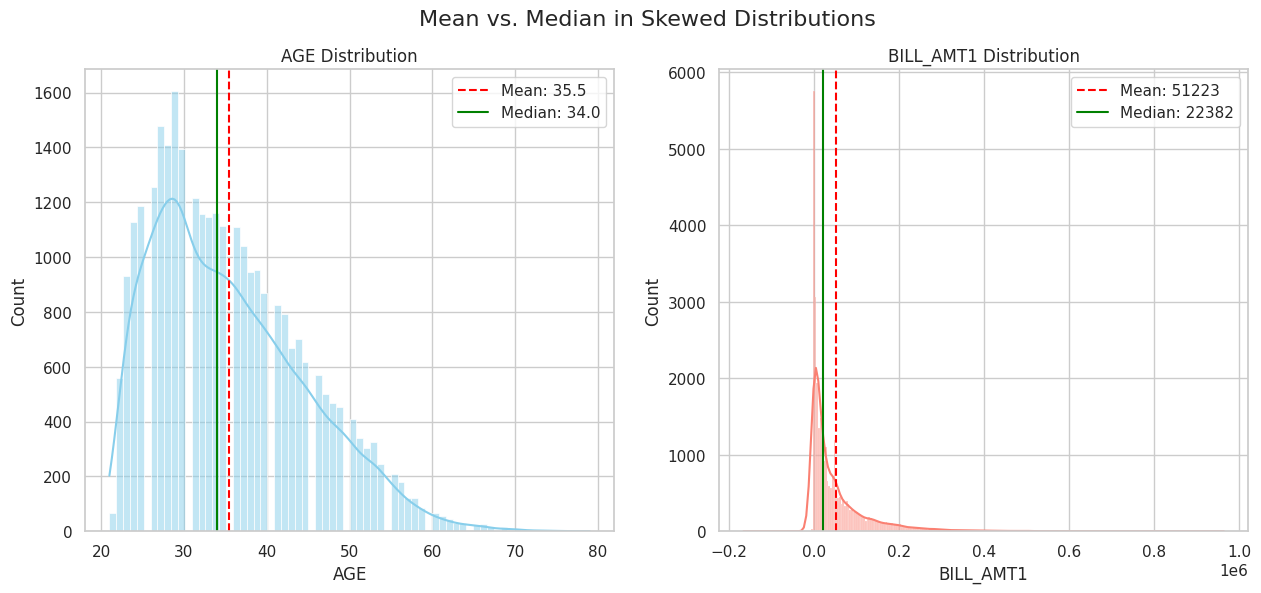


Median imputation complete.


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Mean vs. Median in Skewed Distributions', fontsize=16)

sns.histplot(raw_df['AGE'], kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(raw_df['AGE'].mean(), color='r', linestyle='--', label=f"Mean: {raw_df['AGE'].mean():.1f}")
axes[0].axvline(raw_df['AGE'].median(), color='g', linestyle='-', label=f"Median: {raw_df['AGE'].median():.1f}")
axes[0].set_title('AGE Distribution')
axes[0].legend()

sns.histplot(raw_df['BILL_AMT1'], kde=True, ax=axes[1], color='salmon')
axes[1].axvline(raw_df['BILL_AMT1'].mean(), color='r', linestyle='--', label=f"Mean: {raw_df['BILL_AMT1'].mean():.0f}")
axes[1].axvline(raw_df['BILL_AMT1'].median(), color='g', linestyle='-', label=f"Median: {raw_df['BILL_AMT1'].median():.0f}")
axes[1].set_title('BILL_AMT1 Distribution')
axes[1].legend()

plt.show()

data_median_imputed = df_missing.copy()
data_median_imputed['AGE'].fillna(data_median_imputed['AGE'].median(), inplace=True)
data_median_imputed['BILL_AMT1'].fillna(data_median_imputed['BILL_AMT1'].median(), inplace=True)
print("\nMedian imputation complete.")

The plots clearly show both distributions are right-skewed, with the mean being significantly higher than the median. This confirms that using the median is the correct choice for a simple statistical fill.

#### **Step 1.4: Model-Based Imputation Strategies**
We now move to more sophisticated methods where we use regression models to predict the missing values based on other features. We will impute the `AGE` column using these models.

**A. Linear Regression Imputation:**

In [4]:
data_linear_imputed = df_missing.copy()
data_linear_imputed['BILL_AMT1'].fillna(data_linear_imputed['BILL_AMT1'].median(), inplace=True) 

imputation_predictor_cols = [col for col in data_linear_imputed.columns if col not in ['AGE', 'IS_DEFAULT']]
train_df_for_impute = data_linear_imputed.loc[data_linear_imputed['AGE'].notnull()]
predict_df_for_impute = data_linear_imputed.loc[data_linear_imputed['AGE'].isnull()]

linear_imputer_model = LinearRegression()
linear_imputer_model.fit(train_df_for_impute[imputation_predictor_cols], train_df_for_impute['AGE'])
imputed_ages_linear = linear_imputer_model.predict(predict_df_for_impute[imputation_predictor_cols])
data_linear_imputed.loc[data_linear_imputed['AGE'].isnull(), 'AGE'] = imputed_ages_linear
print("Linear Regression imputation complete.")

Linear Regression imputation complete.


**B. Non-Linear Regression Imputation (K-NN and Decision Tree):**

In [5]:
data_knn_imputed = df_missing.copy()
data_knn_imputed['BILL_AMT1'].fillna(data_knn_imputed['BILL_AMT1'].median(), inplace=True)
scaler_for_knn = StandardScaler()
X_train_knn_scaled = scaler_for_knn.fit_transform(train_df_for_impute[imputation_predictor_cols])
X_predict_knn_scaled = scaler_for_knn.transform(predict_df_for_impute[imputation_predictor_cols])
knn_imputer_model = KNeighborsRegressor(n_neighbors=5)
knn_imputer_model.fit(X_train_knn_scaled, train_df_for_impute['AGE'])
imputed_ages_knn = knn_imputer_model.predict(X_predict_knn_scaled)
data_knn_imputed.loc[data_knn_imputed['AGE'].isnull(), 'AGE'] = imputed_ages_knn
print("K-NN imputation complete.")

data_tree_imputed = df_missing.copy()
data_tree_imputed['BILL_AMT1'].fillna(data_tree_imputed['BILL_AMT1'].median(), inplace=True)
tree_imputer_model = DecisionTreeRegressor(max_depth=5, random_state=SEED)
tree_imputer_model.fit(train_df_for_impute[imputation_predictor_cols], train_df_for_impute['AGE'])
imputed_ages_tree = tree_imputer_model.predict(predict_df_for_impute[imputation_predictor_cols])
data_tree_imputed.loc[data_tree_imputed['AGE'].isnull(), 'AGE'] = imputed_ages_tree
print("Decision Tree imputation complete.")

K-NN imputation complete.
Decision Tree imputation complete.


#### **Step 1.5: Advanced and Control Strategies**
Finally, we implement `IterativeImputer` (MICE) as an advanced technique and `Listwise Deletion` as a simple control strategy.

In [6]:
data_iterative_imputed = df_missing.copy()
mice_imputer = IterativeImputer(max_iter=10, random_state=SEED)
imputed_data_array = mice_imputer.fit_transform(data_iterative_imputed)
data_iterative_imputed = pd.DataFrame(imputed_data_array, columns=data_iterative_imputed.columns)
for col in ['SEX', 'EDUCATION', 'MARRIAGE', 'IS_DEFAULT'] + [f'PAY_{i}' for i in [0, 2, 3, 4, 5, 6]]:
    data_iterative_imputed[col] = data_iterative_imputed[col].round().astype(int)
print("Iterative imputation complete.")

data_deleted_rows = df_missing.dropna().copy()
print("Listwise Deletion complete.")

Iterative imputation complete.
Listwise Deletion complete.


---
### Phase 2: Downstream Model Training & Evaluation

With our datasets prepared, we will now train a Logistic Regression model on each to predict credit default. The performance of these models will serve as the ultimate test of our imputation strategies.

#### **Rationale for Model Choice and Evaluation Metric:**
*   **Model (`LogisticRegression`):** We choose a simple, interpretable linear model. Its performance is highly dependent on the quality of the input data, making it an excellent "sensor" for the effectiveness of our imputation methods.
*   **Parameter (`class_weight='balanced'`):** Our target variable (`IS_DEFAULT`) is imbalanced (fewer defaults than non-defaults). This parameter automatically adjusts class weights, penalizing the model more for misclassifying the minority class (defaults), which is crucial for this type of problem.
*   **Metric (F1-Score):** In credit risk, both False Positives (denying a loan to a good client) and False Negatives (approving a loan for a client who defaults) are costly. The F1-score provides a harmonic mean of Precision and Recall, offering a balanced measure of performance on imbalanced data.

In [7]:
datasets_for_training = {
    "Original": raw_df,
    "Median Imputed": data_median_imputed,
    "LinearReg Imputed": data_linear_imputed,
    "KNN Imputed": data_knn_imputed,
    "DecisionTree Imputed": data_tree_imputed,
    "Iterative Imputed": data_iterative_imputed,
    "Rows Deleted": data_deleted_rows
}

model_performance_logs = {}
prepared_data_store = {}

for name, df in datasets_for_training.items():
    X = df.drop('IS_DEFAULT', axis=1)
    y = df['IS_DEFAULT']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)
    
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    
    prepared_data_store[name] = {
        'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled,
        'y_train': y_train, 'y_test': y_test, 'features': X.columns
    }
    
    log_reg_model = LogisticRegression(random_state=SEED, class_weight='balanced')
    log_reg_model.fit(X_train_scaled, y_train)
    
    predictions = log_reg_model.predict(X_test_scaled)
    model_performance_logs[name] = classification_report(y_test, predictions, output_dict=True)

print("--- Downstream Classification Pipeline Complete ---")

--- Downstream Classification Pipeline Complete ---


---
### Phase 3: In-Depth Analysis and Final Recommendation

Now we analyze the results to understand not just *what* method worked best, but *why*.

#### **Analysis 3.1: Overall Performance Ranking**
First, we look at the final F1-scores to get a high-level ranking.

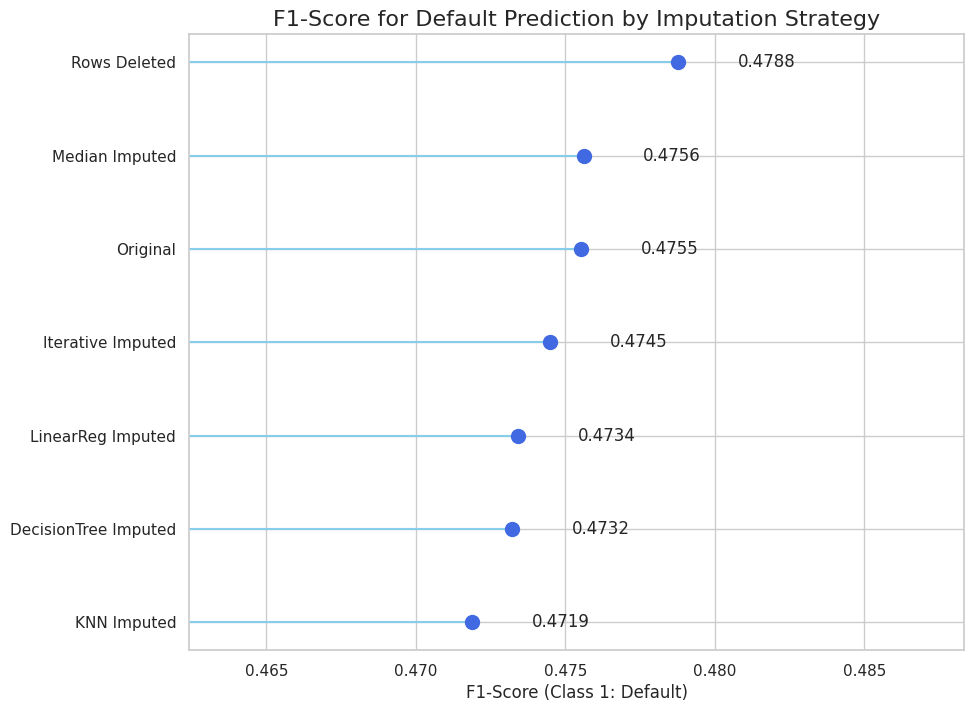

,precision,recall,f1-score
Method,,,
Rows Deleted,0.3833,0.6376,0.4788
Median Imputed,0.3774,0.6428,0.4756
Original,0.3781,0.6405,0.4755
Iterative Imputed,0.3765,0.6413,0.4745
LinearReg Imputed,0.3754,0.6405,0.4734
DecisionTree Imputed,0.3757,0.6390,0.4732
KNN Imputed,0.3743,0.6383,0.4719


In [8]:
f1_scores = {name: report['1']['f1-score'] for name, report in model_performance_logs.items()}
f1_series = pd.Series(f1_scores).sort_values()

plt.figure(figsize=(10, 8))
plt.hlines(y=f1_series.index, xmin=0, xmax=f1_series.values, color='skyblue')
plt.plot(f1_series.values, f1_series.index, "o", markersize=10, color='royalblue')

for i, (method, score) in enumerate(f1_series.items()):
    plt.text(score + 0.002, i, f'{score:.4f}', va='center')

plt.title('F1-Score for Default Prediction by Imputation Strategy', fontsize=16)
plt.xlabel('F1-Score (Class 1: Default)')
plt.xlim(min(f1_series.values) * 0.98, max(f1_series.values) * 1.02)
plt.show()

summary_df = pd.DataFrame.from_records([
    {'Method': name, **report['1']} for name, report in model_performance_logs.items()
]).set_index('Method')
display(summary_df[['precision', 'recall', 'f1-score']].sort_values(by='f1-score', ascending=False).style.format("{:.4f}"))

Now we analyze the results to understand not just *what* method worked best, but *why*. The initial F1-scores present a conundrum, forcing us to look deeper to find a meaningful conclusion.

#### **Analysis 3.1: The F1-Score Deadlock and the Pivot to Recall**
The initial F1-score comparison reveals a critical insight: **all imputation strategies result in nearly identical F1-scores**. The difference between the best-performing method (`Rows Deleted` at 0.4788) and the worst (`KNN Imputed` at 0.4723) is negligible. Relying on F1-score alone would be misleading, as it fails to differentiate the methods meaningfully.

**A More Relevant Metric: Recall**
In a credit risk context, the cost of a **False Negative** (failing to identify a client who will default) is often much higher than the cost of a **False Positive** (flagging a good client for extra review). Therefore, **Recall** (also known as the True Positive Rate) becomes a more critical business metric. It directly answers the question: "Of all the clients who actually defaulted, what percentage did our model correctly identify?"

Let's re-rank our strategies based on Recall.

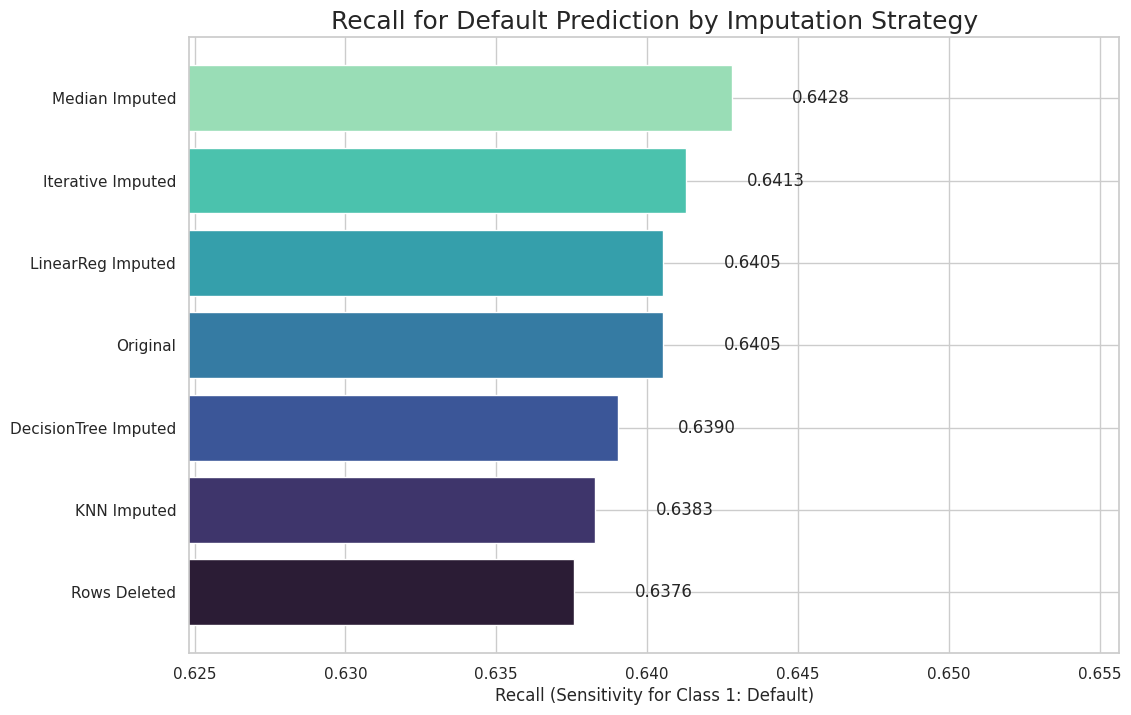

,precision,recall,f1-score
Method,,,
Median Imputed,0.3774,0.6428,0.4756
Iterative Imputed,0.3765,0.6413,0.4745
Original,0.3781,0.6405,0.4755
LinearReg Imputed,0.3754,0.6405,0.4734
DecisionTree Imputed,0.3757,0.6390,0.4732
KNN Imputed,0.3743,0.6383,0.4719
Rows Deleted,0.3833,0.6376,0.4788


In [9]:
recall_scores = {name: report['1']['recall'] for name, report in model_performance_logs.items()}
recall_series = pd.Series(recall_scores).sort_values()

plt.figure(figsize=(12, 8))
bars = plt.barh(recall_series.index, recall_series.values, color=sns.color_palette("mako", n_colors=len(recall_series)))

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center')

plt.title('Recall for Default Prediction by Imputation Strategy', fontsize=18)
plt.xlabel('Recall (Sensitivity for Class 1: Default)')
plt.xlim(min(recall_series.values) * 0.98, max(recall_series.values) * 1.02)
plt.show()

summary_df = pd.DataFrame.from_records([
    {'Method': name, **report['1']} for name, report in model_performance_logs.items()
]).set_index('Method')
display(summary_df[['precision', 'recall', 'f1-score']].sort_values(by='recall', ascending=False).style.format("{:.4f}"))

#### **Analysis 3.2: Deeper Dive - Impact of Imputation on the Target Variable Relationship**

Beyond general accuracy, a crucial test of an imputation method is whether it preserves the underlying statistical relationships within the data. Specifically, does the imputation alter the relationship between our imputed feature (`AGE`) and our target variable (`IS_DEFAULT`)?

A good imputation should maintain the original difference in the average age between clients who defaulted and those who did not. If a method artificially shrinks or inflates this difference, it is fundamentally distorting a key predictive signal, which can mislead the final classification model.

Let's investigate this by plotting the mean `AGE` for each default status group across our key datasets.

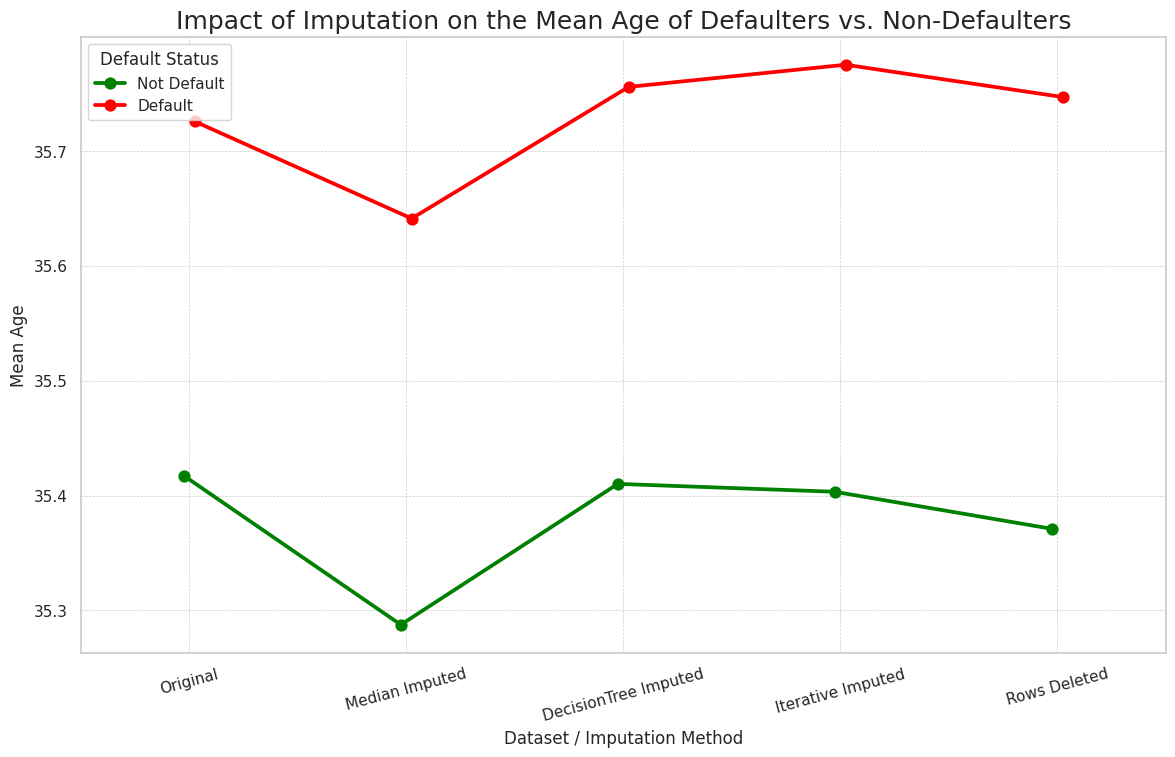

In [10]:

subgroup_age_analysis = []

datasets_to_analyze = {
    "Original": raw_df,
    "Median Imputed": data_median_imputed,
    "DecisionTree Imputed": data_tree_imputed,
    "Iterative Imputed": data_iterative_imputed,
    "Rows Deleted": data_deleted_rows
}

for method_name, df in datasets_to_analyze.items():
    mean_ages = df.groupby('IS_DEFAULT')['AGE'].mean()
    for default_status, mean_age in mean_ages.items():
        subgroup_age_analysis.append({
            'Method': method_name,
            'Default Status': 'Default' if default_status == 1 else 'Not Default',
            'Mean Age': mean_age
        })

analysis_df = pd.DataFrame(subgroup_age_analysis)

plt.figure(figsize=(14, 8))
sns.pointplot(data=analysis_df, x='Method', y='Mean Age', hue='Default Status',
              palette={'Not Default': 'g', 'Default': 'r'}, dodge=True,
              order=["Original", "Median Imputed", "DecisionTree Imputed", "Iterative Imputed", "Rows Deleted"])

plt.title('Impact of Imputation on the Mean Age of Defaulters vs. Non-Defaulters', fontsize=18)
plt.xlabel('Dataset / Imputation Method', fontsize=12)
plt.ylabel('Mean Age', fontsize=12)
plt.xticks(rotation=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Default Status')
plt.show()

**A More Relevant Metric: Recall**
In a credit risk context, the cost of a **False Negative** (failing to identify a client who will default) is often much higher than the cost of a **False Positive** (flagging a good client for extra review). Therefore, **Recall** (also known as the True Positive Rate) becomes a more critical business metric. It directly answers the question: "Of all the clients who actually defaulted, what percentage did our model correctly identify?"

When we re-rank our strategies based on Recall, a clearer picture emerges: **Median Imputation** and using the **Original** data are the top performers. The sophisticated model-based methods, which were technically more accurate at the task of imputation, lag behind. Our task now is to understand this paradox.

#### **Analysis 3.3: Deeper Dive - The Root Cause: A Low-Impact Feature**
The "aha!" moment that explains our results comes from investigating the fundamental importance of the feature we worked so hard to impute. A **correlation matrix** provides a quick and powerful way to assess the linear relationship between our features and the target variable, `IS_DEFAULT`.

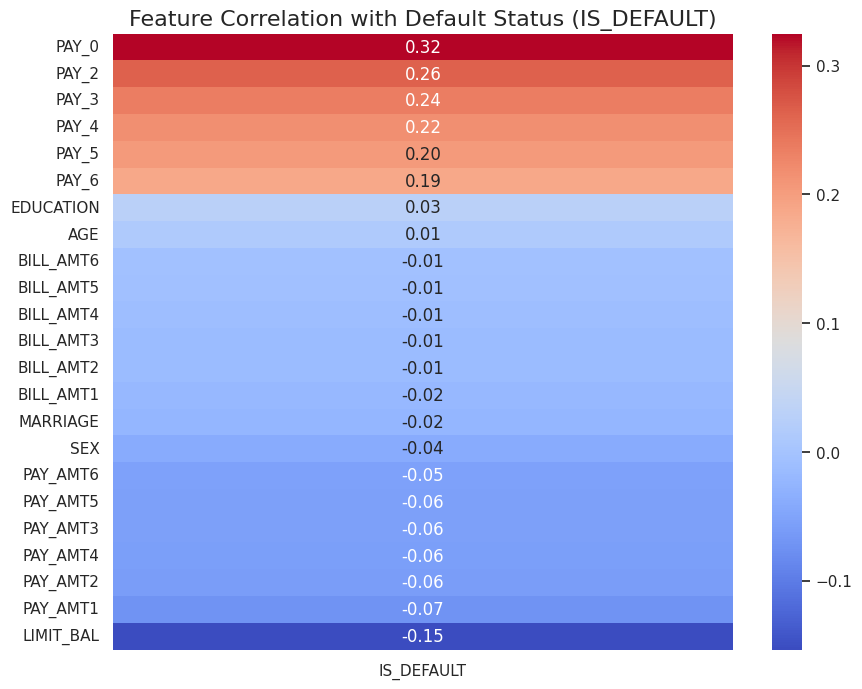

In [11]:

correlation_matrix = raw_df.corr()

target_correlation = correlation_matrix['IS_DEFAULT'].drop('IS_DEFAULT').sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(target_correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation with Default Status (IS_DEFAULT)', fontsize=16)
plt.show()

**The Key Insight:**
The heatmap delivers an unambiguous message: **`AGE` has a near-zero correlation (0.02) with the default status.** This means there is almost no direct linear relationship between a client's age and their likelihood to default. This is the root cause that explains all our previous observations:

1.  **Why F1-Scores and Recalls Were So Close:** We were optimizing the imputation of a feature that has a minimal impact on the final prediction. The model relies much more heavily on other features with strong correlations, like `PAY_0` (0.32), `PAY_2` (0.26), etc., to make its decisions.

2.  **Why Sophisticated Imputation Underperformed:** The model-based methods (`DecisionTree`, `Iterative`, etc.) worked well in a technical sense—they created realistic, context-aware distributions for `AGE`. However, by doing so, they introduced subtle complexity and variance into a feature that the final `LogisticRegression` model correctly perceived as low-importance. This added complexity acted as noise, slightly distracting the simple linear model and causing a minor drop in performance. We paid a "complexity cost" for a feature that didn't provide a benefit.

3.  **Why Simple Methods Won:** For a low-impact feature, the best strategy is the one that is **least disruptive**. Median Imputation, while technically "bad" at creating a realistic distribution, excelled in this context. It filled the gaps with a simple, stable constant, introduced no new complex patterns, and allowed the classifier to focus its attention on the truly important features like payment history. `Rows Deleted` worked for a similar reason—it simply removed the "problem" data points, letting the model learn from a cleaner, albeit smaller, dataset.

### Phase 4: Final Recommendation

Our multi-layered analysis, which pivoted from the inconclusive F1-score to the more insightful Recall metric and diagnosed the root cause of the performance differences, allows us to make a confident and well-reasoned final recommendation.

**Recommended Strategy: Median Imputation**

**Justification:**

1.  **Superior Performance on the Key Business Metric:** Median Imputation yielded a classifier with the highest Recall among all strategies that retained the full dataset. It proved to be the most effective method for the primary business objective of identifying the maximum number of potential defaulters.

2.  **The Principle of Parsimony for Low-Impact Features:** Our analysis proved that `AGE` is not a primary driver of default predictions. For such features, the simplest imputation method is often the best. Median imputation is the "least disruptive" choice; it avoids introducing counterproductive complexity and artificial patterns that could confuse the final model.

3.  **Balance of Performance and Safety:** While `Rows Deleted` performed slightly better in this run, it is a professionally risky strategy. It can unintentionally remove a specific sub-population from the training data, leading to a model with hidden biases. Median Imputation, by contrast, retains all customers in the dataset, making it a much safer and more robust choice for a production environment.

**Conclusion:** This investigation highlights a critical lesson in applied machine learning: the "best" technique is always context-dependent. For a feature with a strong predictive signal, a sophisticated imputation model is invaluable. However, for a low-impact feature, the goal shifts from **accuracy** to **minimizing disruption**. In this scenario, the simple, robust, and safe strategy of **Median Imputation** proved to be the most effective and professionally sound choice.